In [1]:
import requests
import pandas as pd
import time

url = "http://oqmd.org/oqmdapi/formationenergy"

fields = "entry_id,name,spacegroup,ntypes,band_gap,delta_e,stability"
filters = "element_set=(O)"

all_data = []
limit = 1000
offset = 0
target_total = 5000

print(f"Downloading {target_total} samples for the project...")

while len(all_data) < target_total:
    request_url = f"{url}?limit={limit}&offset={offset}&fields={fields}&filter={filters}"
    
    try:
        response = requests.get(request_url)
        data = response.json()['data']
        
        if not data:
            break
        
        all_data.extend(data)
        print(f"Downloaded: {len(all_data)} entries...")
        
        offset += limit
        time.sleep(0.2)
        
    except Exception as e:
        print(f"Error occurred: {e}")
        break

df = pd.DataFrame(all_data[:target_total])

df.to_csv("oqmd_oxides_project_data.csv", index=False)

print(f"\nSaved {df.shape[0]} entries to 'oqmd_oxides_project_data.csv'.")
print(df.head())

Downloaded: 1000 entries...
Downloaded: 2000 entries...
Downloaded: 3000 entries...
Downloaded: 4000 entries...
Downloaded: 5000 entries...

Saved 5000 entries to 'oqmd_oxides_project_data.csv'.
  name  entry_id spacegroup  ntypes  band_gap   delta_e  stability
0  ZnO     20684      Pm-3m       2     0.000 -0.932217   0.717532
1  CuO     11469      Fm-3m       2     0.000 -0.673436   0.158098
2  TiO     17898      Fm-3m       2     0.000 -2.522310   0.259050
3   VO      5578      Fm-3m       2     1.191 -2.259973   0.002871
4  BeO     20737      F-43m       2     7.021 -2.960379   0.005831


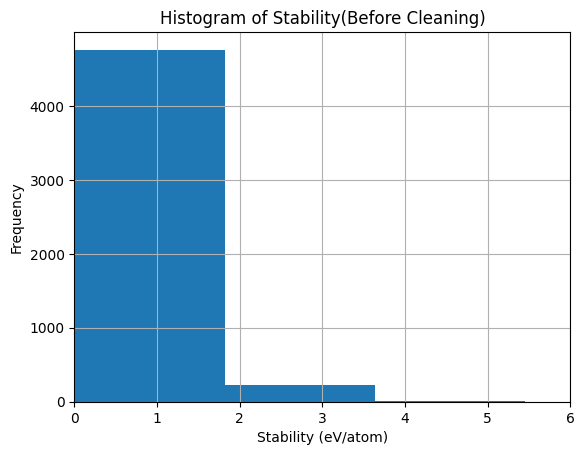

In [2]:
import matplotlib.pyplot as plt
df['stability'].hist(bins=30)
plt.xlabel('Stability (eV/atom)')
plt.ylabel('Frequency')
plt.title('Histogram of Stability(Before Cleaning)')
plt.xlim(0,6)
plt.savefig("Histogram of Stability(Before Cleaning).png", dpi=300, bbox_inches='tight')
plt.show()

In [3]:
df = df.sort_values('stability', ascending=True)

df_clean = df.drop_duplicates(subset='name', keep='first').copy()
df_clean = df_clean[df_clean['stability'] < 1.0] 

print(f"begain number: {len(df)} -> after number: {len(df_clean)}")

begain number: 5000 -> after number: 3040


In [4]:
from pymatgen.core import Composition

def check_non_metal(formula):
    comp = Composition(formula)

    valid_elements = [e for e in comp.elements if e.is_metal or e.is_metalloid]
    return len(valid_elements) > 0

df_clean['is_valid'] = df_clean['name'].apply(check_non_metal)

non_metal_count = len(df_clean) - df_clean['is_valid'].sum()
print(f"total: {len(df_clean)}")
print(f"non metal: {non_metal_count}")
print(non_metal_count / len(df_clean) )

if non_metal_count > 0:
    print(df_clean[~df_clean['is_valid']]['name'].head(10))


df_clean = df_clean[df_clean['is_valid']].copy()
print(len(df_clean))



total: 3040
non metal: 22
0.007236842105263158
1728        CO2
1566          O
1789        NO2
2876      H2SO4
1259     SCl2O2
2124       SeO2
2218       Cl2O
847     H8SN2O4
1754        H2O
62          CSO
Name: name, dtype: object
3018


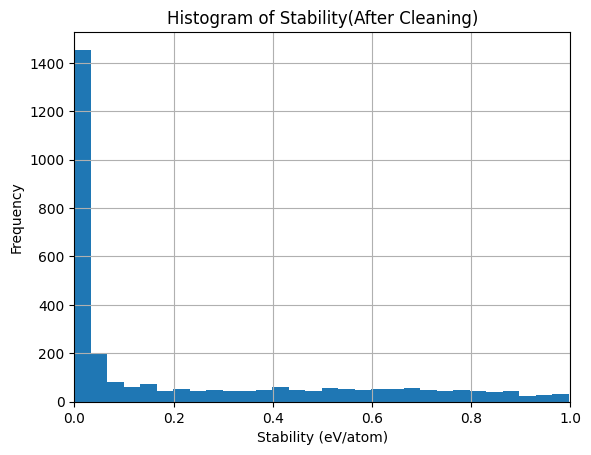

In [5]:
import matplotlib.pyplot as plt
df_clean['stability'].hist(bins=30)
plt.xlabel('Stability (eV/atom)')
plt.ylabel('Frequency')
plt.title('Histogram of Stability(After Cleaning)')
plt.xlim(0,1)
plt.savefig("Histogram of Stability(After Cleaning).png", dpi=300, bbox_inches='tight')
plt.show()

In [6]:
from pymatgen.core import Composition
df_comp = df_clean.copy()
df_comp['composition'] = df_comp['name'].apply(lambda x: Composition(x))
df_comp.head()

,name,entry_id,spacegroup,ntypes,band_gap,delta_e,stability,is_valid,composition
1796,Cs2TeO3,11050,P321,3,3.561,-1.702111,0.0,True,"(Cs, Te, O)"
73,LiO3,22226,Imm2,2,0.000,-0.918965,0.0,True,"(Li, O)"
74,AlCuO2,4794,R-3m,3,2.332,-2.331729,0.0,True,"(Al, Cu, O)"
1749,NaClO4,5091,Cmcm,3,5.908,-0.883576,0.0,True,"(Na, Cl, O)"
877,SrSb2O6,13345,P-31m,3,3.094,-2.202781,0.0,True,"(Sr, Sb, O)"


In [7]:
from matminer.featurizers.composition.composite import ElementProperty

el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie', impute_nan=False)
el_prop_featuriser.set_n_jobs(1)
df_featurized = el_prop_featuriser.featurize_dataframe(df_comp, col_id='composition')

print(df_featurized.shape)  
print(df_featurized.isnull().sum().sum()) 
df_featurized.head()

c:\Users\51648\Documents\GitHub\ML4MSD-HW-YueZ\.venv\Lib\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/3018 [00:00<?, ?it/s]

(3018, 141)
37


,name,entry_id,spacegroup,ntypes,band_gap,delta_e,stability,is_valid,composition,MagpieData minimum Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
1796,Cs2TeO3,11050,P321,3,3.561,-1.702111,0.0,True,"(Cs, Te, O)",8.0,...,0.0,0.0,0.0,0.0,12.0,229.0,217.0,107.666667,95.666667,12.0
73,LiO3,22226,Imm2,2,0.000,-0.918965,0.0,True,"(Li, O)",3.0,...,0.0,0.0,0.0,0.0,12.0,229.0,217.0,66.250000,81.375000,12.0
74,AlCuO2,4794,R-3m,3,2.332,-2.331729,0.0,True,"(Al, Cu, O)",8.0,...,0.0,0.0,0.0,0.0,12.0,225.0,213.0,118.500000,106.500000,12.0
1749,NaClO4,5091,Cmcm,3,5.908,-0.883576,0.0,True,"(Na, Cl, O)",8.0,...,0.0,0.0,0.0,0.0,12.0,229.0,217.0,56.833333,59.777778,12.0
877,SrSb2O6,13345,P-31m,3,3.094,-2.202781,0.0,True,"(Sr, Sb, O)",8.0,...,0.0,0.0,0.0,0.0,12.0,225.0,213.0,69.888889,77.185185,12.0


In [8]:
df_featurized = df_featurized.dropna()

print(f"Final shape for training: {df_featurized.shape}")
print(f"Remaining nulls: {df_featurized.isnull().sum().sum()}")

Final shape for training: (2981, 141)
Remaining nulls: 0


Number of features before cleaning: 135
Columns with very small variance: ['is_valid', 'MagpieData maximum NsValence', 'MagpieData minimum NdValence', 'MagpieData minimum NfValence', 'MagpieData minimum NsUnfilled', 'MagpieData minimum NdUnfilled', 'MagpieData minimum NfUnfilled', 'MagpieData minimum GSbandgap', 'MagpieData minimum GSmagmom']
Number of features after removing small variance columns: 126
Columns to drop due to high correlation: {'MagpieData range Number', 'MagpieData mode Number', 'MagpieData minimum AtomicWeight', 'MagpieData range NdUnfilled', 'MagpieData range MendeleevNumber', 'MagpieData minimum MeltingT', 'MagpieData range NsUnfilled', 'MagpieData minimum CovalentRadius', 'MagpieData range GSbandgap', 'MagpieData maximum NsUnfilled', 'MagpieData maximum SpaceGroupNumber', 'MagpieData range NfValence', 'MagpieData range Column', 'MagpieData minimum Number', 'MagpieData range AtomicWeight', 'MagpieData range NfUnfilled', 'MagpieData maximum NfValence', 'MagpieData a

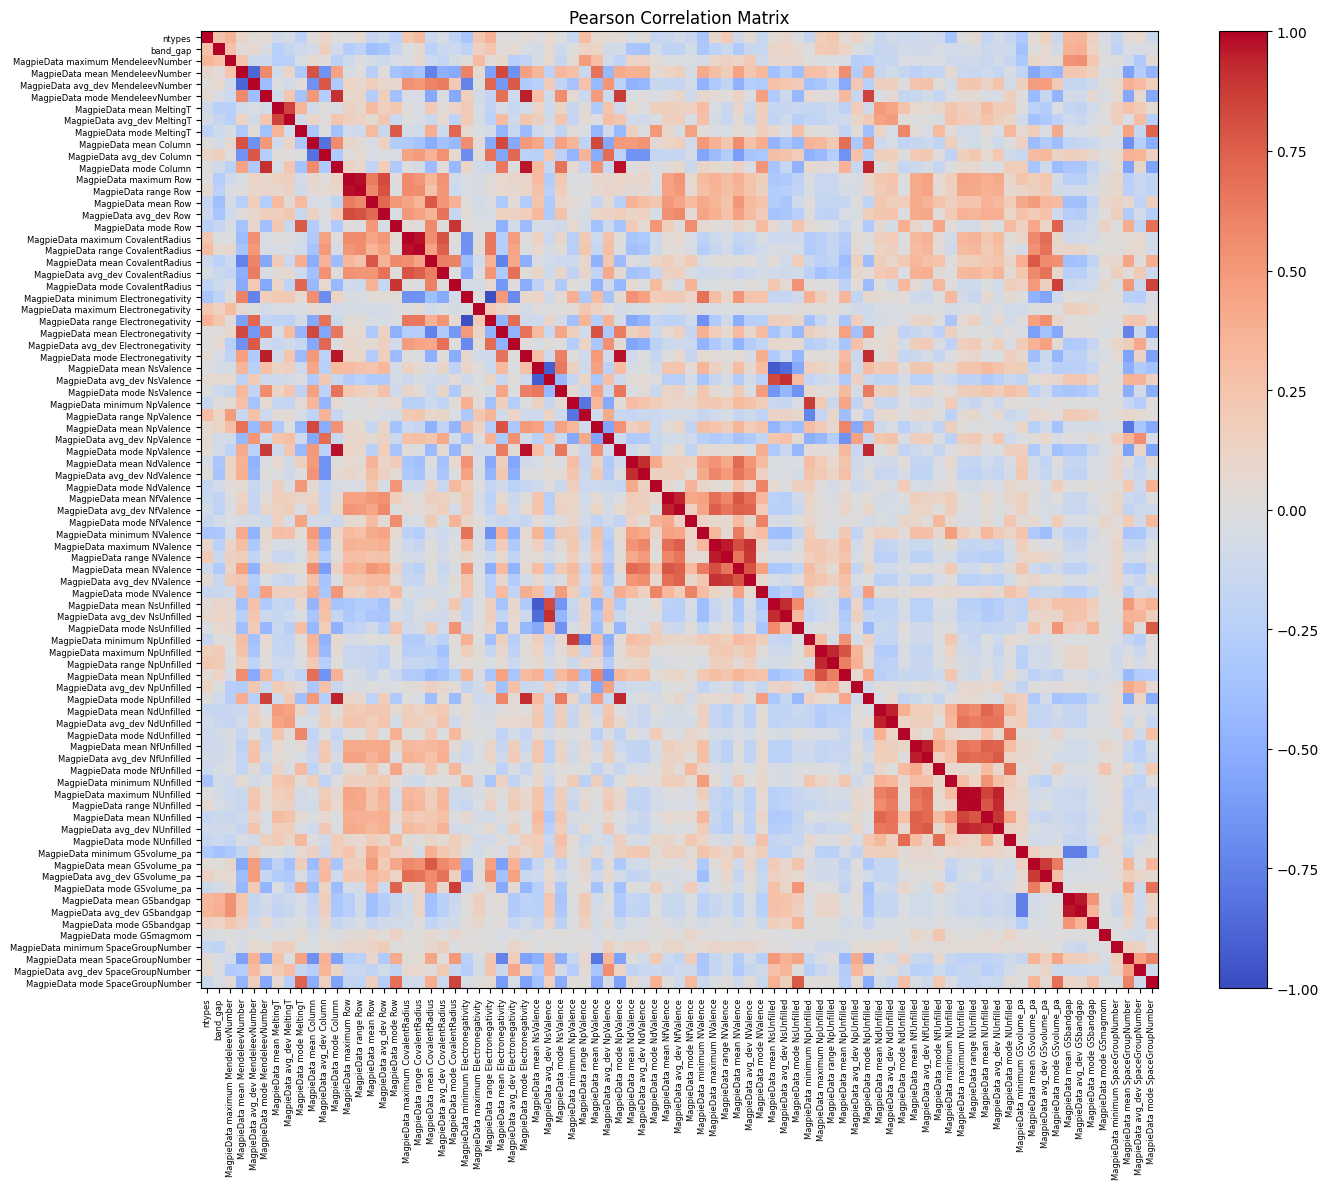

In [9]:
import matplotlib.pyplot as plt
y = df_featurized['stability']  
X_all = df_featurized.drop(columns=['stability', 'spacegroup', 'composition', 'name', 'entry_id','delta_e'])  

print("Number of features before cleaning:", X_all.shape[1])

small_var_cols = X_all.columns[X_all.var() < 1e-5].tolist()
print("Columns with very small variance:", small_var_cols)
X_all = X_all.drop(columns=small_var_cols)
corr_matrix = X_all.corr(method='pearson')
print("Number of features after removing small variance columns:", X_all.shape[1])

threshold = 0.99
to_drop = set()
for col in corr_matrix.columns:
    high_corr = corr_matrix.index[(corr_matrix[col].abs() > threshold) & (corr_matrix.index != col)]
    to_drop.update(high_corr)
print("Columns to drop due to high correlation:", to_drop)
X = X_all.drop(columns=list(to_drop))
print("Number of features after removing highly correlated columns:", X.shape[1])

corr_matrix = X.corr(method='pearson')

plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Pearson Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=6)
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, 
                                                          test_size=test_fraction, 
                                                          random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=42)
print(f"Training fraction: {X_train.shape[0] / X.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X.shape[0]:.2f}")


Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


In [11]:
from sklearn.metrics import mean_absolute_error

mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))

print(f"Baseline MAE (predicting mean stability): {baseline_mae:.4f} eV/atom")

Baseline MAE (predicting mean stability): 0.2646 eV/atom


Training RF models:   0%|          | 0/4 [00:00<?, ?it/s]

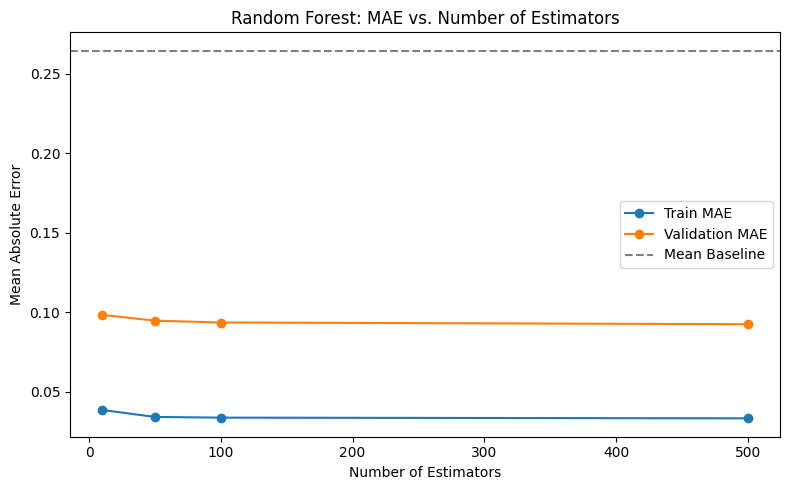

In [12]:
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm

n_estimators_list = [10, 50, 100, 500]
train_maes = []
val_maes = []

for n in tqdm(n_estimators_list, desc='Training RF models'):
    rf = RandomForestRegressor(n_estimators=n, random_state=17, n_jobs=1)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)
    train_maes.append(mean_absolute_error(y_train, y_train_pred))
    val_maes.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, train_maes, marker='o', label='Train MAE')
plt.plot(n_estimators_list, val_maes, marker='o', label='Validation MAE')
plt.axhline(baseline_mae, color='gray', linestyle='--', label='Mean Baseline')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('Random Forest: MAE vs. Number of Estimators')
plt.legend()
plt.tight_layout()
plt.savefig("composition_rf_n_estimators_mae.png", dpi=300, bbox_inches='tight')
plt.show()

RFE Progress:   0%|          | 0/16 [00:00<?, ?it/s]

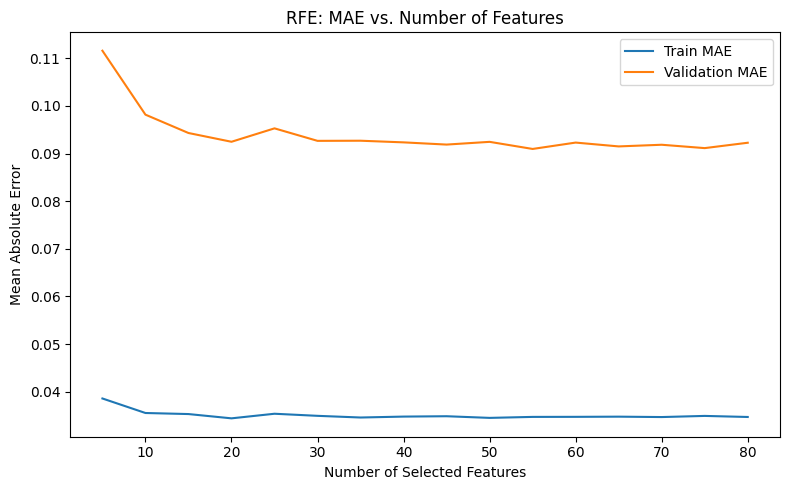

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm

rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
n_features_list = list(range(5, X_val.shape[1]+1, 5))
val_errors = []
train_errors = []
selected_features_dict = {}

for n_features in tqdm(n_features_list, desc='RFE Progress'):
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=5)
    rfe.fit(X_train, y_train)
    selected_features_dict[n_features] = list(X.columns[rfe.support_])
    X_train_rfe = rfe.transform(X_train)
    rf.fit(X_train_rfe, y_train)
    y_train_pred = rf.predict(X_train_rfe)
    train_errors.append(mean_absolute_error(y_train, y_train_pred))
    X_val_rfe = rfe.transform(X_val)
    y_val_pred = rf.predict(X_val_rfe)
    val_errors.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_errors, label='Train MAE')
plt.plot(n_features_list, val_errors, label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('RFE: MAE vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.savefig("composition_rfe_feature_selection_mae.png", dpi=300, bbox_inches='tight')
plt.show()

Selected 30 features.


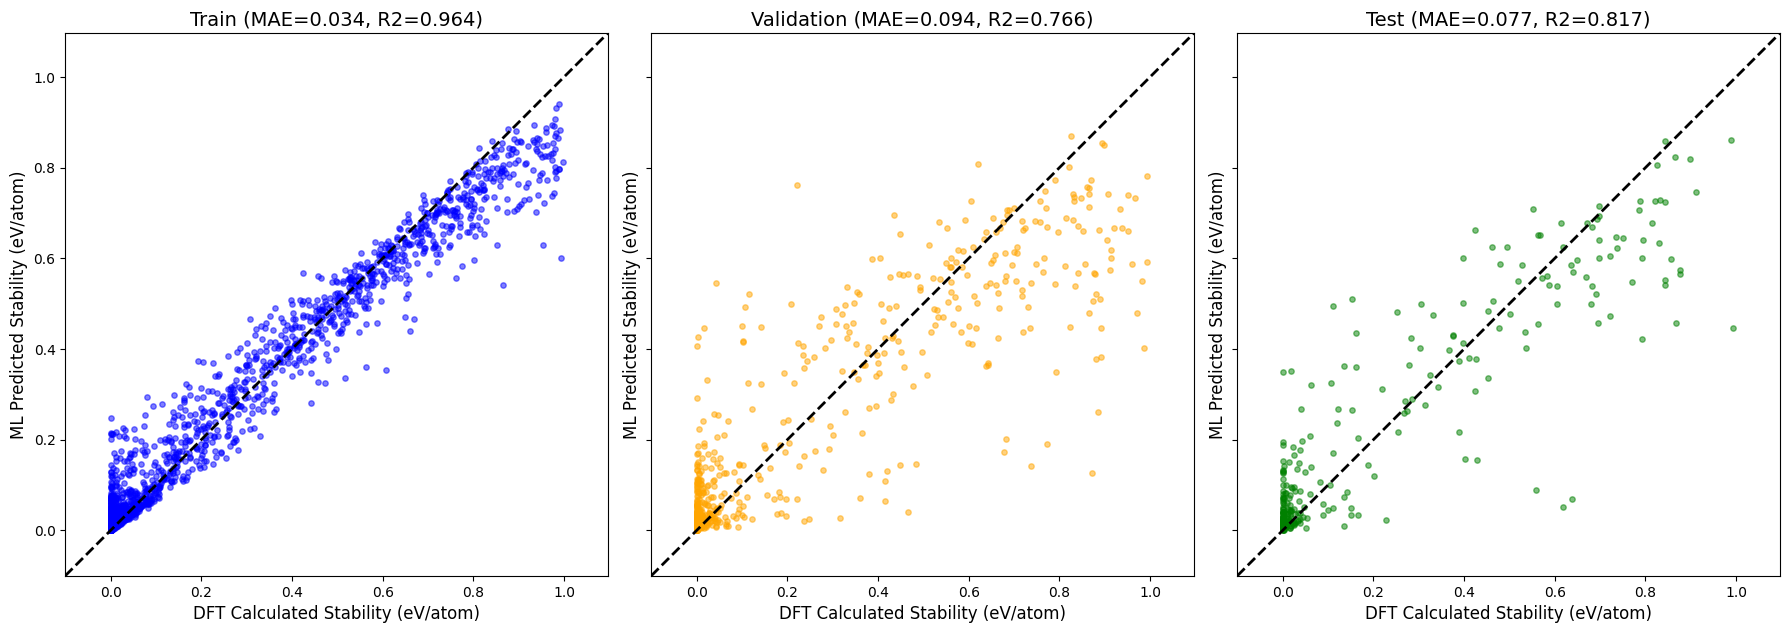

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

final_features = selected_features_dict[30]
print(f"Selected {len(final_features)} features.")

rf_final = RandomForestRegressor(n_estimators=100, random_state=17, n_jobs=-1) 

X_train_final = X_train[final_features]
X_val_final = X_val[final_features]
X_test_final = X_test[final_features]

rf_final.fit(X_train_final, y_train)

y_train_pred = rf_final.predict(X_train_final)
y_val_pred = rf_final.predict(X_val_final)
y_test_pred = rf_final.predict(X_test_final)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

min_val = min(y_train.min(), y_train_pred.min()) - 0.1
max_val = max(y_train.max(), y_train_pred.max()) + 0.1

for ax, y_true, y_pred, title, color in zip(
    axes, 
    [y_train, y_val, y_test], 
    [y_train_pred, y_val_pred, y_test_pred],
    [f'Train (MAE={mae_train:.3f}, R2={r2_train:.3f})', 
     f'Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})', 
     f'Test (MAE={mae_test:.3f}, R2={r2_test:.3f})'],
    ['blue', 'orange', 'green']
):
    ax.scatter(y_true, y_pred, alpha=0.5, color=color, s=15)
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2) 
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('DFT Calculated Stability (eV/atom)', fontsize=12)
    ax.set_ylabel('ML Predicted Stability (eV/atom)', fontsize=12)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
fig.savefig("composition_parity_final.png", dpi=300, bbox_inches='tight')
plt.show()

In [15]:
df_struct_feat = pd.get_dummies(df_clean["spacegroup"], prefix="sg")
df_struct_feat.head()

,sg_Ama2,sg_Amm2,sg_C2,sg_C2/c,sg_C2/m,sg_Cc,sg_Ccca,sg_Cccm,sg_Cm,sg_Cmc21,...,sg_Pnn2,sg_Pnna,sg_Pnnm,sg_R-3,sg_R-3c,sg_R-3m,sg_R3,sg_R32,sg_R3c,sg_R3m
1796,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
73,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
74,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1749,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
877,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
y = df_clean["stability"]
X_struct = df_struct_feat.copy()

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_struct, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_struct.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_struct.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_struct.shape[0]:.2f}")

Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


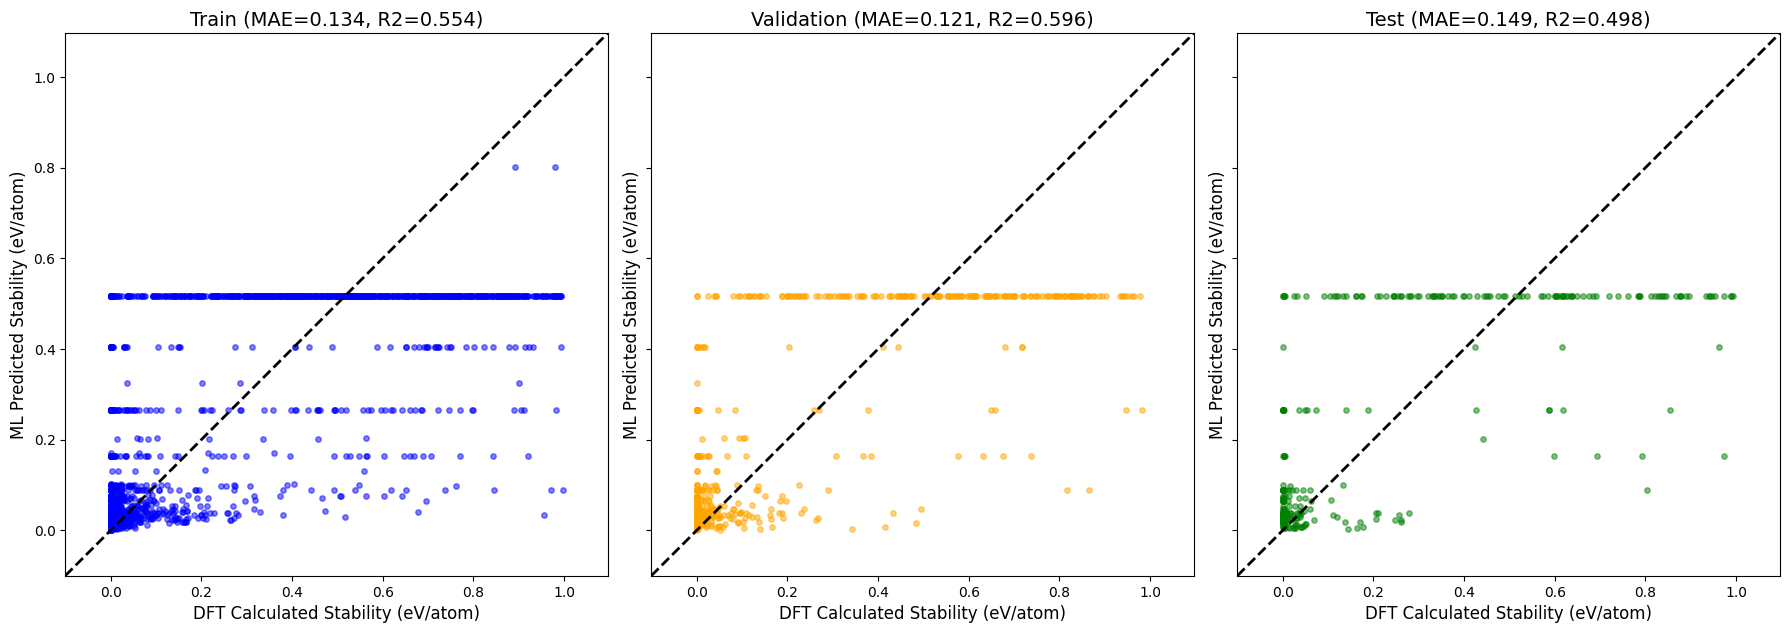

In [17]:
from sklearn.metrics import r2_score

rf_final = RandomForestRegressor(n_estimators=100, random_state=17, n_jobs=1)
rf_final.fit(X_train, y_train)


y_train_pred = rf_final.predict(X_train)
y_val_pred = rf_final.predict(X_val)
y_test_pred = rf_final.predict(X_test)

# Calculate metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

min_val = min(y_train.min(), y_train_pred.min()) - 0.1
max_val = max(y_train.max(), y_train_pred.max()) + 0.1

for ax, y_true, y_pred, title, color in zip(
    axes, 
    [y_train, y_val, y_test], 
    [y_train_pred, y_val_pred, y_test_pred],
    [f'Train (MAE={mae_train:.3f}, R2={r2_train:.3f})', 
     f'Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})', 
     f'Test (MAE={mae_test:.3f}, R2={r2_test:.3f})'],
    ['blue', 'orange', 'green']
):
    ax.scatter(y_true, y_pred, alpha=0.5, color=color, s=15)
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2) 
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('DFT Calculated Stability (eV/atom)', fontsize=12)
    ax.set_ylabel('ML Predicted Stability (eV/atom)', fontsize=12)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
fig.savefig("structure_parity_final.png", dpi=300, bbox_inches='tight')
plt.show()

In [18]:
import json

summary = {
    "composition_model": {
        "model": "RandomForest",
        "n_estimators": 100,
        "features": 30,
        "train_mae": 0.034,
        "val_mae": 0.094,
        "test_mae": 0.077,
        "train_r2": 0.964,
        "val_r2": 0.766,
        "test_r2": 0.817
    },
    "structure_model": {
        "model": "RandomForest",
        "n_estimators": 100,
        "features": 126,
        "train_mae": 0.134,
        "val_mae": 0.121,
        "test_mae": 0.149,
        "train_r2": 0.554,
        "val_r2": 0.596,
        "test_r2": 0.498
    },
    "baseline_mae": 0.2515
}

with open("performance_summary.json", "w") as f:
    json.dump(summary, f, indent=4)

print("Saved performance_summary.json")





Saved performance_summary.json
